# Reactivity trends over structural features

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from tabulate import tabulate

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_motif_boxplot_stripplot,
    plot_violins_w_percent,
    plot_violins_w_percent_groups,
    format_small_plot,
)
from dms_3d_features.format_tables import dataframe_column_table, heatmap_table
from dms_3d_features.stats import r2

## extra functions

In [3]:
def create_summary_table(df, y_column, threshold=-5.45, greater_than=False, sort=True):
    # Calculate percentages and counts
    summary = []
    comparison = ">" if greater_than else "<"
    for y_value in df[y_column].unique():
        group = df[df[y_column] == y_value]
        if greater_than:
            percent = (group["ln_r_data"] > threshold).mean() * 100
        else:
            percent = (group["ln_r_data"] < threshold).mean() * 100
        count = len(group)
        summary.append([y_value, f"{percent:.2f}%", count])

    # Sort by percentage descending if sort is True
    if sort:
        summary.sort(key=lambda x: float(x[1][:-1]), reverse=True)

    # Create table
    headers = [y_column, f"% {comparison} {threshold}", "Count"]
    table = tabulate(summary, headers=headers, tablefmt="pipe", floatfmt=".2f")

    print(f"Summary table for {y_column}:")
    print(table)

In [4]:
def plot_residue_trends(df, color="tab:gray"):
    fig = plt.figure(figsize=(3.0, 3.0), dpi=200)
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[:, 1])

    # 5' Residue
    data_range = df["ln_r_data"].max() - df["ln_r_data"].min()
    extra_space = 0.4 * data_range
    xlim_min = df["ln_r_data"].min() - extra_space
    xlim_max = df["ln_r_data"].max()

    plot_violins_w_percent(
        df,
        "ln_r_data",
        "p5_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax1,
    )
    ax1.set_ylabel("5' Residue", labelpad=2)
    ax1.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    format_small_plot(ax1)

    # 3' Residue
    plot_violins_w_percent(
        df,
        "ln_r_data",
        "p3_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax2,
    )
    ax2.set_ylabel("3' Residue", labelpad=2)
    ax2.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    format_small_plot(ax2)

    # Residue Stack
    plot_violins_w_percent(
        df,
        "ln_r_data",
        "r_stack",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax3,
    )
    ax3.set_ylabel("Residue Stack", labelpad=2)
    ax3.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    format_small_plot(ax3)
    plt.tight_layout()

In [5]:
def add_side_diff_column(df):
    df["side_diff"] = [
        abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df["m_token"]
    ]
    df["side_diff"] = df["side_diff"].astype(str)
    return df

In [6]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

## load data 

In [7]:
DATA_PATH = "../data"

In [8]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_helix = df.query("m_token.str.contains('HELIX')").copy()
df = df.query("not m_token.str.contains('HELIX')").copy()
with np.errstate(divide="ignore"):
    df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
df = df.query("r_data_outlier == False").copy()
df = add_side_diff_column(df)
df["stack_type"] = df.apply(assign_stack_type, axis=1)

In [9]:
df_non_wc = df.query("r_type == 'NON-WC'").copy()
df_wc = df.query("r_type == 'WC'").copy()

### format turner rules

In [10]:
df_turner = pd.read_csv("../dms_3d_features/resources/csvs/turner_rules.csv")

In [11]:
turner_rules = {}
for i, row in df_turner.iterrows():
    bp1 = row["strand_1"][0] + row["strand_2"][0]
    bp2 = row["strand_1"][1] + row["strand_2"][1]
    turner_rules[bp1 + " " + bp2] = float(row["dg"])
    if not pd.isnull(row["sym_strand_1"]):
        bp1 = row["sym_strand_1"][0] + row["sym_strand_2"][0]
        bp2 = row["sym_strand_1"][1] + row["sym_strand_2"][1]
        turner_rules[bp1 + " " + bp2] = float(row["dg"])
turner_rules

{'AU AU': -0.93,
 'UA UA': -0.93,
 'AU UA': -1.1,
 'UA AU': -1.33,
 'CG UA': -2.08,
 'AU GC': -2.08,
 'CG AU': -2.11,
 'UA GC': -2.11,
 'GC UA': -2.24,
 'AU CG': -2.24,
 'GC AU': -2.35,
 'UA CG': -2.35,
 'CG GC': -2.36,
 'GC GC': -3.26,
 'CG CG': -3.26,
 'GC CG': -3.42}

In [12]:
dataframe_column_table(df)

          0                    1                    2             3
both_purine      both_pyrimidine           constructs      has_pdbs
likely_pair        m_flank_bp_5p        m_flank_bp_3p m_orientation
      m_pos m_second_flank_bp_5p m_second_flank_bp_3p    m_sequence
m_structure              m_token               n_pdbs     pair_type
     p5_res              p5_type               p3_res       p3_type
     r_data                r_nuc            r_loc_pos         r_pos
     r_type              r_stack             pdb_path     pdb_r_pos
  ln_r_data              z_score       r_data_outlier     side_diff
 stack_type                  NaN                  NaN           NaN


# Probablity of being WC

In [13]:
filtered_column = df["r_data"][df["r_data"] != 0]
min_value = filtered_column.min()
print(min_value)  # approximately ln(min_value) = -9.8

6.000000000000001e-05


In [14]:
# set -inf values to -9.8 the lowest value found
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
df["ln_r_data"].describe()

count    235104.000000
mean         -5.094208
std           1.369991
min          -9.800000
25%          -6.331142
50%          -5.057727
75%          -3.965424
max          -0.853363
Name: ln_r_data, dtype: float64

In [15]:
# Convert 'r_type' to binary (1 for 'WC', 0 for 'NON-WC')
df["r_type_binary"] = df["r_type"].apply(lambda x: 1 if x == "WC" else 0)

# Fit the logistic regression model
model = LogisticRegression()
model.fit(df[["ln_r_data"]], df["r_type_binary"])

# Compute probabilities for the original data
df["prob_WC"] = model.predict_proba(df[["ln_r_data"]])[:, 1]

# Assess the model fit
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)

# Predict classes
y_pred = model.predict(df[["ln_r_data"]])

# Calculate accuracy
accuracy = accuracy_score(df["r_type_binary"], y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(df["r_type_binary"], y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(df["r_type_binary"], y_pred)
print("Classification Report:")
print(class_report)

# Calculate ROC AUC score
roc_auc = roc_auc_score(df["r_type_binary"], df["prob_WC"])
print(f"ROC AUC Score: {roc_auc:.4f}")

# Display the probabilities

Accuracy: 0.9064
Confusion Matrix:
[[123734  11597]
 [ 10399  89374]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92    135331
           1       0.89      0.90      0.89     99773

    accuracy                           0.91    235104
   macro avg       0.90      0.91      0.90    235104
weighted avg       0.91      0.91      0.91    235104

ROC AUC Score: 0.9682


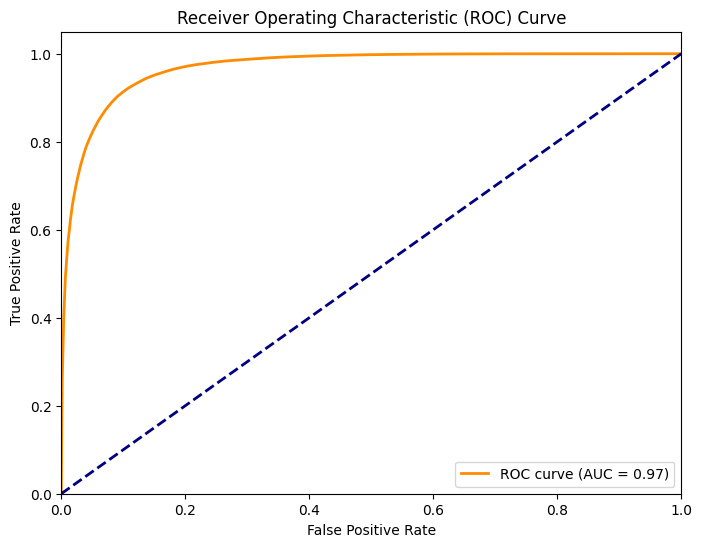

Area Under the Curve (AUC): 0.9682


In [16]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(df["r_type_binary"], df["prob_WC"])

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Create the ROC plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Print the AUC score
print(f"Area Under the Curve (AUC): {roc_auc:.4f}")

In [17]:
df.sort_values("prob_WC", ascending=False)[["ln_r_data", "r_type", "prob_WC"]]

,ln_r_data,r_type,prob_WC
161014,-9.800000,WC,0.999997
18117,-9.800000,WC,0.999997
34407,-9.800000,WC,0.999997
164206,-9.800000,WC,0.999997
88932,-9.800000,WC,0.999997
...,...,...,...
234172,-1.076254,NON-WC,0.000003
234215,-1.013022,NON-WC,0.000002
234191,-0.994414,NON-WC,0.000002
55879,-0.972755,NON-WC,0.000002


In [18]:
# Calculate the absolute difference between each value in the column 'prob_WC' and 0.5
df["abs_diff"] = (df["prob_WC"] - 0.50).abs()

# Find the index of the minimum difference
min_index = df["abs_diff"].idxmin()

# Retrieve the entire row that is closest to 0.5 in the 'prob_WC' column
closest_row = df.loc[min_index]

print("The row with the value in 'prob_WC' closest to 0.5 is:")
print(closest_row["ln_r_data"])

The row with the value in 'prob_WC' closest to 0.5 is:
-5.47505454504809


## logistical regression of being a WC pair

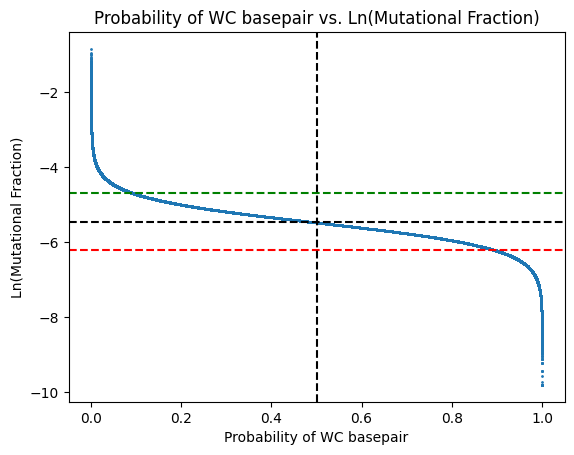

In [19]:
plt.scatter(df["prob_WC"], df["ln_r_data"], s=1)
plt.title("Probability of WC basepair vs. Ln(Mutational Fraction)")
plt.xlabel("Probability of WC basepair")
plt.ylabel("Ln(Mutational Fraction)")
plt.axhline(
    y=-4.68, color="green", linestyle="--"
)  # 10% probability threshold (0.00927901)
plt.axhline(
    y=-5.45, color="black", linestyle="--"
)  # 50% probability threshold (0.0042963)
plt.axhline(
    y=-6.22, color="red", linestyle="--"
)  # 90% probability threshold (0.00198925)
plt.axvline(x=0.5, color="black", linestyle="--")

In [20]:
df["ln_r_data"].describe()

count    235104.000000
mean         -5.094208
std           1.369991
min          -9.800000
25%          -6.331142
50%          -5.057727
75%          -3.965424
max          -0.853363
Name: ln_r_data, dtype: float64

## stats on non-WC with low reactivity

In [21]:
df_below_50 = df.query("ln_r_data < -5.45 and r_type == 'NON-WC'")
print(len(df_below_50))
df_below_90 = df.query("ln_r_data < -6.22 and r_type == 'NON-WC'")
print(len(df_below_90))

12085
2138


In [22]:
for (nuc, m_token), full_g in df_non_wc.groupby(["r_nuc", "m_token"]):
    full_g = full_g.query(f"has_pdbs == True")
    if len(full_g) == 0:
        continue
    g = df_below_50.query(
        f"r_nuc == '{nuc}' and m_token == '{m_token}' and has_pdbs == True"
    )
    print(
        f"{nuc} {m_token} {g.shape[0]}/{full_g.shape[0]}, percentage: {g.shape[0]/full_g.shape[0]*100}"
    )

A 1x0 18/335, percentage: 5.3731343283582085
A 1x1 207/1398, percentage: 14.806866952789699
A 2x0 13/508, percentage: 2.559055118110236
A 2x1 36/2557, percentage: 1.4078998826750098
A 2x2 238/1647, percentage: 14.450516089860352
A 3x0 1/334, percentage: 0.29940119760479045
A 3x1 113/1074, percentage: 10.521415270018622
A 3x2 249/3305, percentage: 7.534039334341906
A 3x3 2/2380, percentage: 0.08403361344537816
A 4x1 1/726, percentage: 0.13774104683195593
A 4x2 36/361, percentage: 9.97229916897507
A 4x3 102/829, percentage: 12.30398069963812
A 4x4 187/1955, percentage: 9.565217391304348
A 5x0 15/309, percentage: 4.854368932038835
A 5x1 8/415, percentage: 1.9277108433734942
A 5x2 0/311, percentage: 0.0
A 5x3 80/933, percentage: 8.57449088960343
A 5x4 84/2481, percentage: 3.3857315598548974
A 6x3 159/1603, percentage: 9.91890205864005
C 1x0 0/184, percentage: 0.0
C 1x1 202/927, percentage: 21.790722761596548
C 2x0 0/173, percentage: 0.0
C 2x1 1/588, percentage: 0.17006802721088435
C 2x2 28

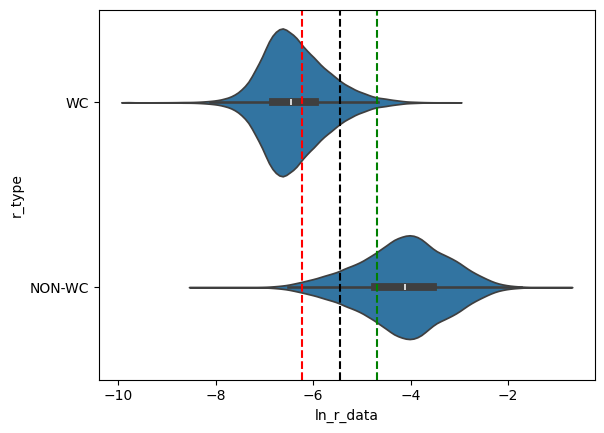

In [23]:
ax = sns.violinplot(x="ln_r_data", y="r_type", data=df)
plt.axvline(
    x=-4.68, color="green", linestyle="--"
)  # 10% probability threshold (0.00927901)
plt.axvline(
    x=-5.45, color="black", linestyle="--"
)  # 50% probability threshold (0.0042963)
plt.axvline(
    x=-6.22, color="red", linestyle="--"
)  # 90% probability threshold (0.00198925)

# Effect of topology

## summary of all topologies

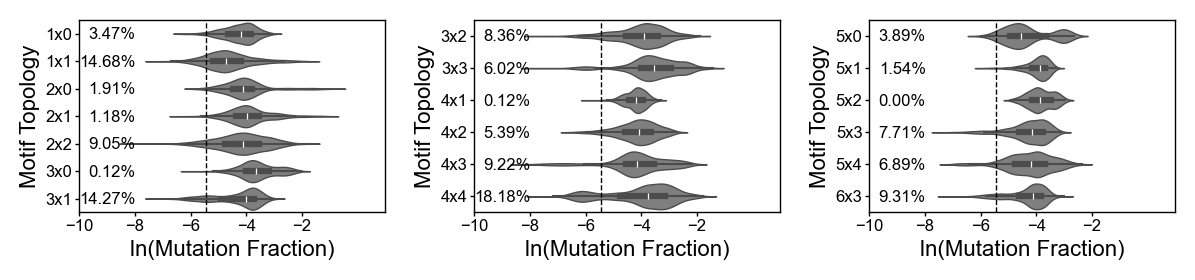

In [24]:
plot_violins_w_percent_groups(
    df_non_wc, "ln_r_data", "m_token", gt_lt="less", n_panels=3, figsize=(1.5, 1.5)
)
plt.tight_layout()

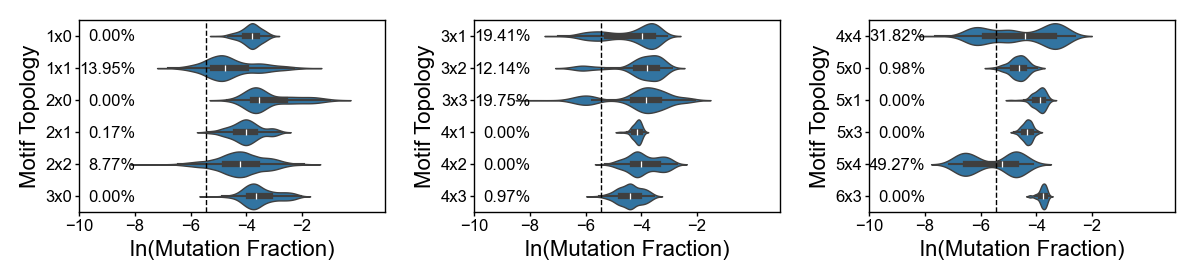

In [25]:
plot_violins_w_percent_groups(
    df_non_wc.query("r_nuc == 'C'"),
    "ln_r_data",
    "m_token",
    gt_lt="less",
    color="tab:blue",
    n_panels=3,
    figsize=(1.5, 1.5),
)
plt.tight_layout()

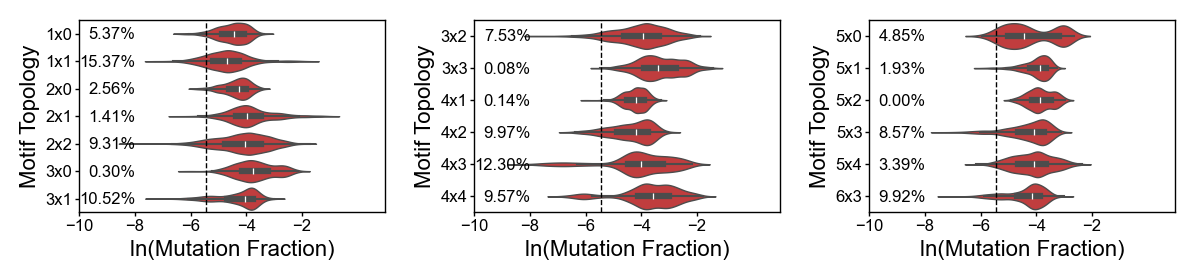

In [26]:
plot_violins_w_percent_groups(
    df_non_wc.query("r_nuc == 'A'"),
    "ln_r_data",
    "m_token",
    gt_lt="less",
    color="tab:red",
    n_panels=3,
    figsize=(1.5, 1.5),
)
plt.tight_layout()

In [27]:
create_summary_table(df_non_wc, "m_token", greater_than=False, sort=True)

Summary table for m_token:
| m_token   | % < -5.45   |   Count |
|:----------|:------------|--------:|
| 4x4       | 18.18%      |    3190 |
| 1x1       | 14.68%      |    4053 |
| 3x1       | 14.27%      |    1857 |
| 6x3       | 9.31%       |    1707 |
| 4x3       | 9.22%       |    1139 |
| 2x2       | 9.05%       |  104330 |
| 3x2       | 8.36%       |    4030 |
| 5x3       | 7.71%       |    1037 |
| 5x4       | 6.89%       |    2686 |
| 3x3       | 6.02%       |    3408 |
| 4x2       | 5.39%       |     668 |
| 5x0       | 3.89%       |     411 |
| 1x0       | 3.47%       |     519 |
| 2x0       | 1.91%       |     681 |
| 5x1       | 1.54%       |     518 |
| 2x1       | 1.18%       |    3145 |
| 4x1       | 0.12%       |     829 |
| 3x0       | 0.12%       |     812 |
| 5x2       | 0.00%       |     311 |


In [28]:
create_summary_table(
    df_non_wc.query("r_nuc == 'C'"), "m_token", greater_than=False, sort=True
)

Summary table for m_token:
| m_token   | % < -5.45   |   Count |
|:----------|:------------|--------:|
| 5x4       | 49.27%      |     205 |
| 4x4       | 31.82%      |    1235 |
| 3x3       | 19.75%      |    1028 |
| 3x1       | 19.41%      |     783 |
| 1x1       | 13.95%      |    1964 |
| 3x2       | 12.14%      |     725 |
| 2x2       | 8.77%       |   49035 |
| 5x0       | 0.98%       |     102 |
| 4x3       | 0.97%       |     310 |
| 2x1       | 0.17%       |     588 |
| 3x0       | 0.00%       |     478 |
| 4x2       | 0.00%       |     307 |
| 1x0       | 0.00%       |     184 |
| 2x0       | 0.00%       |     173 |
| 6x3       | 0.00%       |     104 |
| 5x1       | 0.00%       |     103 |
| 5x3       | 0.00%       |     104 |
| 4x1       | 0.00%       |     103 |


In [29]:
create_summary_table(
    df_non_wc.query("r_nuc == 'A'"), "m_token", greater_than=False, sort=True
)

Summary table for m_token:
| m_token   | % < -5.45   |   Count |
|:----------|:------------|--------:|
| 1x1       | 15.37%      |    2089 |
| 4x3       | 12.30%      |     829 |
| 3x1       | 10.52%      |    1074 |
| 4x2       | 9.97%       |     361 |
| 6x3       | 9.92%       |    1603 |
| 4x4       | 9.57%       |    1955 |
| 2x2       | 9.31%       |   55295 |
| 5x3       | 8.57%       |     933 |
| 3x2       | 7.53%       |    3305 |
| 1x0       | 5.37%       |     335 |
| 5x0       | 4.85%       |     309 |
| 5x4       | 3.39%       |    2481 |
| 2x0       | 2.56%       |     508 |
| 5x1       | 1.93%       |     415 |
| 2x1       | 1.41%       |    2557 |
| 3x0       | 0.30%       |     334 |
| 4x1       | 0.14%       |     726 |
| 3x3       | 0.08%       |    2380 |
| 5x2       | 0.00%       |     311 |


In [30]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != ''"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']}-{row['likely_pair']}-{row['m_token']}", axis=1
)
create_summary_table(df_non_wc_pair, "cat", greater_than=False, sort=True)

Summary table for cat:
| cat      | % < -5.45   |   Count |
|:---------|:------------|--------:|
| C-CC-3x3 | 97.12%      |     104 |
| C-CC-4x4 | 48.18%      |     411 |
| C-CA-1x1 | 33.38%      |     668 |
| C-CA-4x4 | 31.50%      |     619 |
| A-AG-1x1 | 29.52%      |     559 |
| A-AG-2x2 | 21.85%      |   13823 |
| A-AC-1x1 | 17.34%      |     669 |
| C-CA-3x3 | 16.59%      |     615 |
| A-AC-4x4 | 15.97%      |     620 |
| C-CU-2x2 | 15.03%      |   19321 |
| A-AG-4x4 | 8.57%       |    1027 |
| C-CU-1x1 | 7.21%       |     624 |
| A-AA-2x2 | 6.84%       |   25053 |
| C-CC-2x2 | 5.06%       |   13291 |
| A-AA-1x1 | 4.65%       |     861 |
| C-CA-2x2 | 4.40%       |   16423 |
| A-AC-2x2 | 2.52%       |   16419 |
| C-CC-1x1 | 0.89%       |     672 |
| A-AC-3x3 | 0.32%       |     619 |
| A-AG-3x3 | 0.00%       |    1450 |
| C-CU-3x3 | 0.00%       |     309 |
| A-AU-3x3 | 0.00%       |     103 |
| A-AU-4x4 | 0.00%       |     101 |
| C-CU-4x4 | 0.00%       |     205 |
| A-AA-3x3 | 0.

## difference in sides 

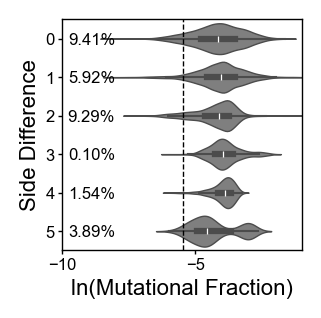

In [31]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_sub = df_non_wc.query("m_token != '6x3'").copy()
plot_violins_w_percent(
    df_sub,
    "ln_r_data",
    "side_diff",
    color="tab:gray",
    gt_lt="less",
    xlim=(-10, -1),
    text_offset=2.0,
    ax=ax,
)
ax.set_ylabel("Side Difference", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
format_small_plot(ax)

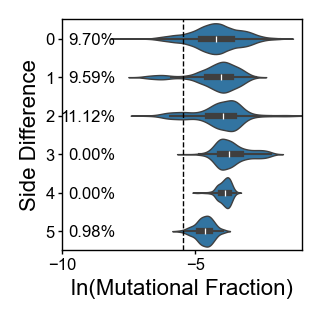

In [32]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_sub = df_non_wc.query("m_token != '6x3'").copy()
plot_violins_w_percent(
    df_sub.query("r_nuc == 'C'"),
    "ln_r_data",
    "side_diff",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    text_offset=2.0,
    ax=ax,
)
ax.set_ylabel("Side Difference", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
format_small_plot(ax)

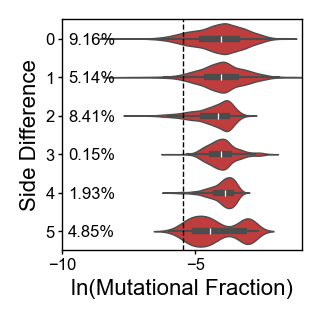

In [33]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_sub = df_non_wc.query("m_token != '6x3'").copy()
plot_violins_w_percent(
    df_sub.query("r_nuc == 'A'"),
    "ln_r_data",
    "side_diff",
    color="tab:red",
    gt_lt="less",
    xlim=(-10, -1),
    text_offset=2.0,
    ax=ax,
)
ax.set_ylabel("Side Difference", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
format_small_plot(ax)

## stacking

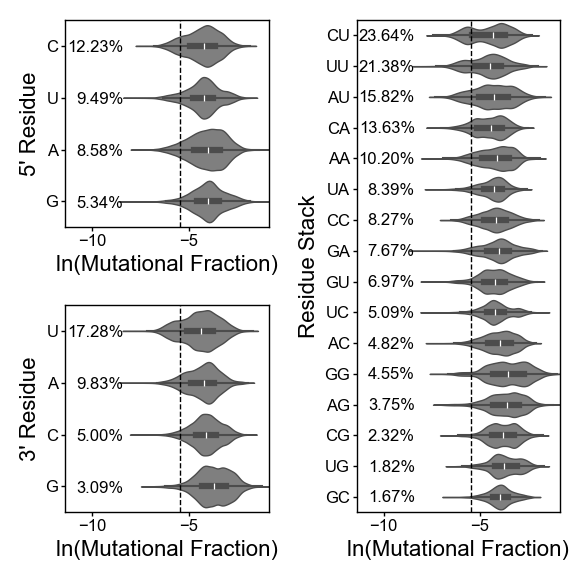

In [34]:
plot_residue_trends(df_non_wc)

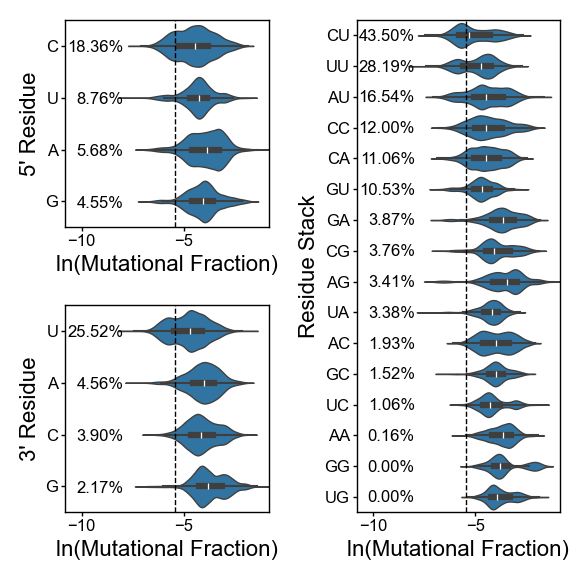

In [35]:
plot_residue_trends(df_non_wc.query('r_nuc == "C"'), color="tab:blue")

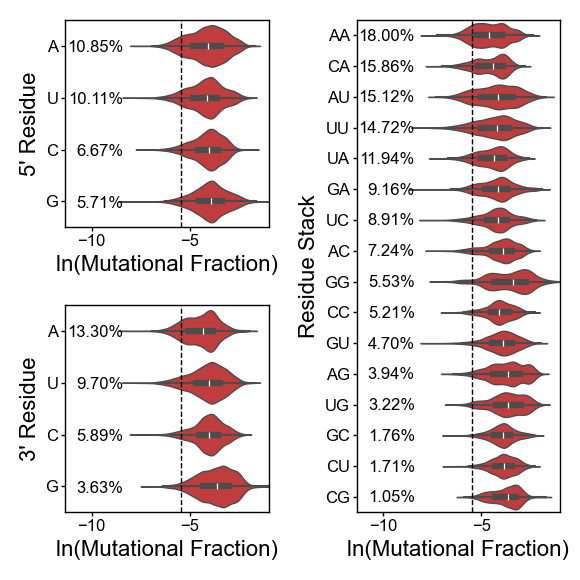

In [36]:
plot_residue_trends(df_non_wc.query('r_nuc == "A"'), color="tab:red")

In [37]:
create_summary_table(df_non_wc, "r_stack", greater_than=False, sort=True)

Summary table for r_stack:
| r_stack   | % < -5.45   |   Count |
|:----------|:------------|--------:|
| CU        | 23.64%      |    7255 |
| UU        | 21.38%      |    8971 |
| AU        | 15.82%      |    9246 |
| CA        | 13.63%      |    8579 |
| AA        | 10.20%      |    9846 |
| UA        | 8.39%       |   10398 |
| CC        | 8.27%       |    8611 |
| GA        | 7.67%       |    9904 |
| GU        | 6.97%       |    6745 |
| UC        | 5.09%       |   10041 |
| AC        | 4.82%       |   11120 |
| GG        | 4.55%       |    5226 |
| AG        | 3.75%       |    8486 |
| CG        | 2.32%       |    6117 |
| UG        | 1.82%       |    6646 |
| GC        | 1.67%       |    8140 |


# Trends in specific toplogy

## bulges

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:426: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


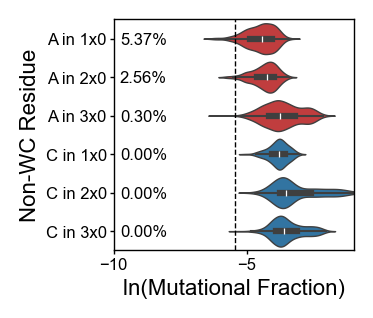

In [38]:
df_sub = df_non_wc.query("m_token.str.endswith('x0') and r_type == 'NON-WC'").copy()
df_sub = df_sub.query("m_token != '5x0'")
df_sub["cat"] = df_sub.apply(
    lambda row: f"{row['r_nuc']} in {row['m_token']}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_sub,
    "ln_r_data",
    "cat",
    colors=["tab:red", "tab:red", "tab:red", "tab:blue", "tab:blue", "tab:blue"],
    gt_lt="less",
    xlim=(-10, -1),
    text_offset=2.0,
    ax=ax,
)
ax.set_ylabel("Non-WC Residue", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
format_small_plot(ax)

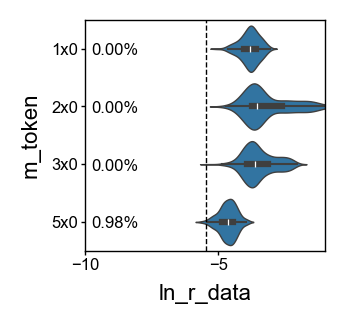

In [39]:
df_sub = df.query(
    "m_token.str.endswith('x0') and r_nuc == 'C' and r_type == 'NON-WC'"
).copy()
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_sub,
    "ln_r_data",
    "m_token",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    text_offset=2.0,
    ax=ax,
)
format_small_plot(ax)

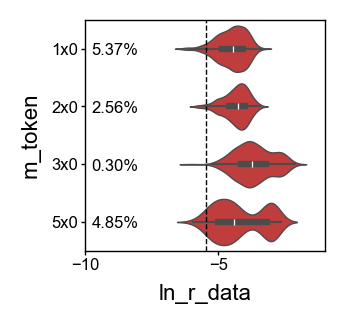

In [40]:
df_sub = df.query(
    "m_token.str.endswith('x0') and r_nuc == 'A' and r_type == 'NON-WC'"
).copy()
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_sub,
    "ln_r_data",
    "m_token",
    color="tab:red",
    gt_lt="less",
    xlim=(-10, -1),
    text_offset=2.0,
    ax=ax,
)
format_small_plot(ax)

### 1-0

#### Cs

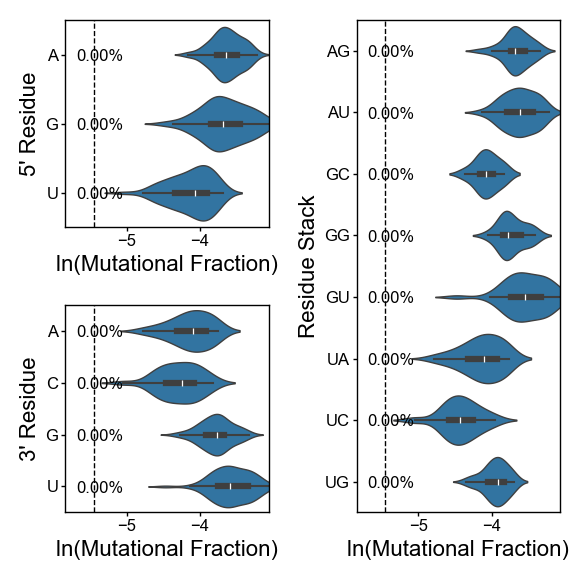

In [41]:
df_sub = df.query(f"m_token == '1x0' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
fig = plot_residue_trends(df_sub, color="tab:blue")

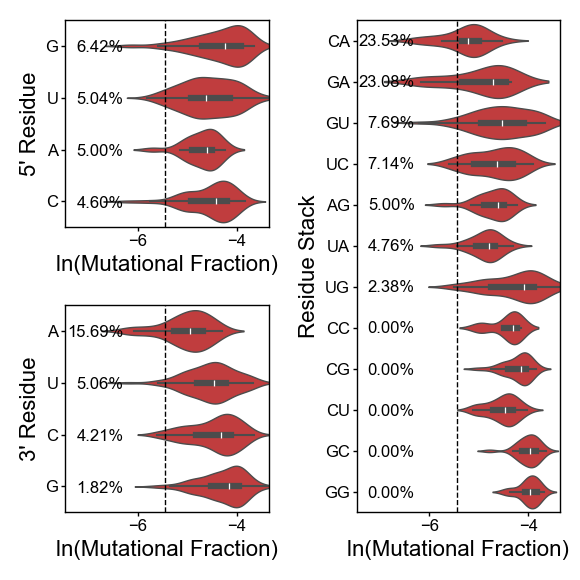

In [42]:
df_sub = df.query(f"m_token == '1x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
fig = plot_residue_trends(df_sub, color="tab:red")

#### compare A vs C

In [43]:
df.query("m_token == '1x0' and r_nuc == 'A' and r_type == 'NON-WC'")["r_data"].mean()

0.012484059701492538

In [44]:
df.query("m_token == '1x0' and r_nuc == 'C' and r_type == 'NON-WC'")["r_data"].mean()

0.02305641304347826

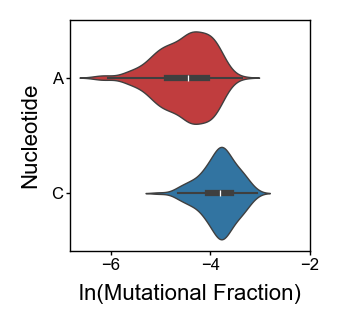

In [45]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_sub = df.query("m_token == '1x0' and r_type == 'NON-WC'").copy()
sns.violinplot(
    x="ln_r_data",
    y="r_nuc",
    data=df_sub,
    hue="r_nuc",
    linewidth=0.5,
    density_norm="width",
    order=["A", "C"],
    palette=["tab:red", "tab:blue"],
    ax=ax,
)
ax.set_xlabel("ln(Mutational Fraction)")
ax.set_ylabel("Nucleotide")
ax.set_xticks(
    [
        -6,
        -4,
        -2,
    ]
)
format_small_plot(ax)

In [46]:
df_sub_1 = df.query("m_token == '1x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub_2 = df.query("m_token == '1x0' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
ks_2samp(df_sub_1["r_data"], df_sub_2["r_data"])

KstestResult(statistic=0.5438027255029202, pvalue=7.789314828245629e-33, statistic_location=0.017050000000000003, statistic_sign=1)

### 2-0

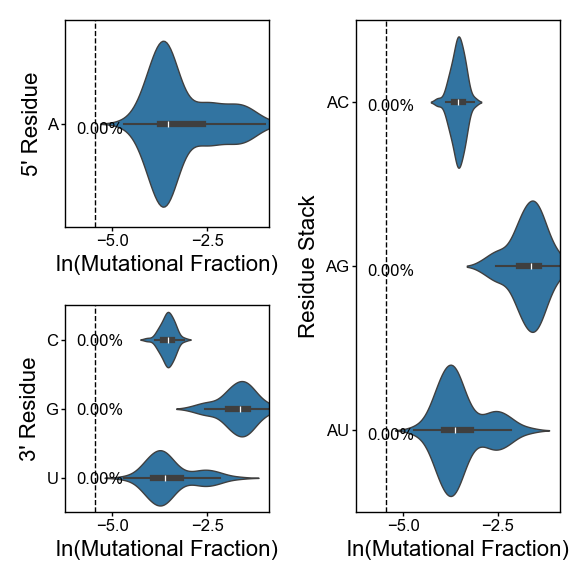

In [47]:
df_sub = df.query(f"m_token == '2x0' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
fig = plot_residue_trends(df_sub, color="tab:blue")

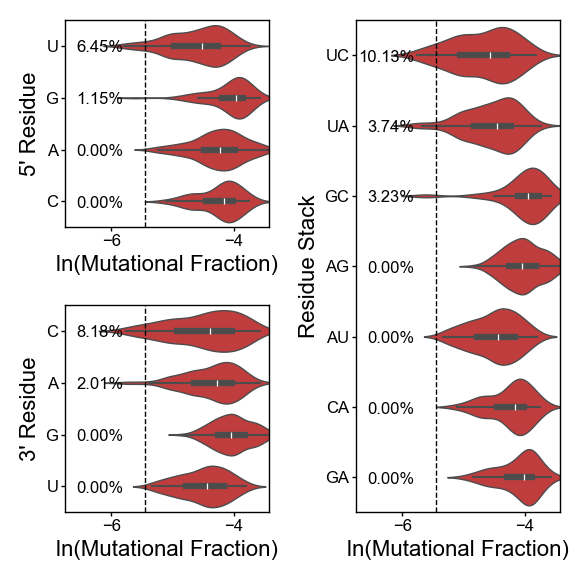

In [48]:
df_sub = df.query(f"m_token == '2x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
fig = plot_residue_trends(df_sub, color="tab:red")

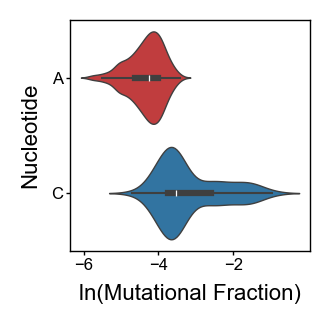

In [49]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_sub = df.query("m_token == '2x0' and r_type == 'NON-WC'").copy()
sns.violinplot(
    x="ln_r_data",
    y="r_nuc",
    data=df_sub,
    hue="r_nuc",
    linewidth=0.5,
    density_norm="width",
    order=["A", "C"],
    palette=["tab:blue", "tab:red"],
    ax=ax,
)
ax.set_xlabel("ln(Mutational Fraction)")
ax.set_ylabel("Nucleotide")
ax.set_xticks(
    [
        -6,
        -4,
        -2,
    ]
)
format_small_plot(ax)

## mismatches

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:426: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


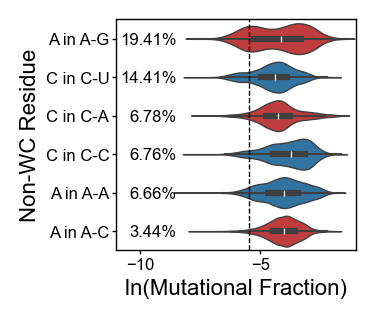

In [50]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != ''"
).copy()
df_non_wc_pair = df_non_wc_pair.query("likely_pair != 'AU'")
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_non_wc_pair,
    "ln_r_data",
    "cat",
    gt_lt="less",
    xlim=(-11, -1),
    text_offset=2.5,
    colors=["tab:red", "tab:blue", "tab:red", "tab:blue", "tab:blue", "tab:red"],
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Non-WC Residue", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
format_small_plot(ax)

### 1x1

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:426: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


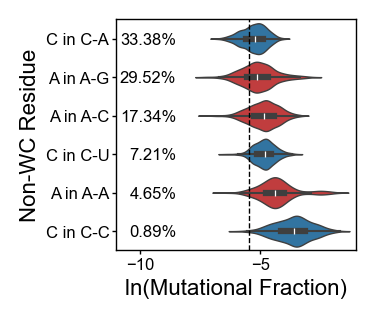

In [51]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '1x1'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_non_wc_pair,
    "ln_r_data",
    "cat",
    gt_lt="less",
    xlim=(-11, -1),
    text_offset=2.5,
    colors=["tab:blue", "tab:red", "tab:red", "tab:blue", "tab:red", "tab:blue"],
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Non-WC Residue", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
format_small_plot(ax)

### 2x2 mismatches

In [52]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '2x2'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']}-{row['likely_pair']}", axis=1
)

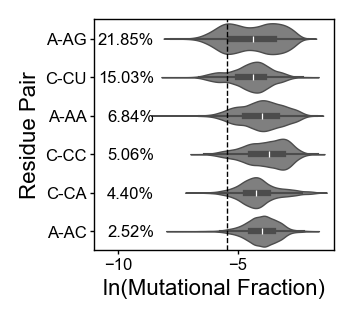

In [53]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_non_wc_pair,
    "ln_r_data",
    "cat",
    gt_lt="less",
    xlim=(-11, -1),
    text_offset=2.5,
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Residue Pair", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
format_small_plot(ax)

# High reactivity 

In [54]:
df_high = df_non_wc.query("r_data > 0.15").copy()

In [55]:
for (nuc, m_token), full_g in df_non_wc.groupby(["r_nuc", "m_token"]):
    g = df_high.query(f"r_nuc == '{nuc}' and m_token == '{m_token}'")
    if len(g) == 0:
        continue
    print(
        f"{nuc} {m_token} {g.shape[0]}/{full_g.shape[0]}, percentage: {g.shape[0]/full_g.shape[0]*100}"
    )

A 1x1 3/2089, percentage: 0.14360938247965532
A 2x1 78/2557, percentage: 3.0504497457958544
A 2x2 14/55295, percentage: 0.025318744913644997
A 3x2 1/3305, percentage: 0.0302571860816944
A 3x3 63/2380, percentage: 2.6470588235294117
A 4x4 7/1955, percentage: 0.35805626598465473
C 1x1 4/1964, percentage: 0.20366598778004072
C 2x0 22/173, percentage: 12.716763005780345
C 2x2 109/49035, percentage: 0.22229020087692464


In [56]:
df_high["r_stack"].value_counts()

GG    178
AG     75
AU     13
UC     13
UG     10
GA      6
CG      4
AA      1
UU      1
Name: r_stack, dtype: int64

In [57]:
178 / sum(df_high["r_stack"].value_counts()) * 100

59.136212624584715

In [58]:
(178 + 75 + 10) / sum(df_high["r_stack"].value_counts()) * 100

87.37541528239203

In [59]:
df_non_wc["r_stack"].value_counts()

AC    11120
UA    10398
UC    10041
GA     9904
AA     9846
AU     9246
UU     8971
CC     8611
CA     8579
AG     8486
GC     8140
CU     7255
GU     6745
UG     6646
CG     6117
GG     5226
Name: r_stack, dtype: int64

# second stack analysis


In [60]:
df.columns

Index(['both_purine', 'both_pyrimidine', 'constructs', 'has_pdbs',
       'likely_pair', 'm_flank_bp_5p', 'm_flank_bp_3p', 'm_orientation',
       'm_pos', 'm_second_flank_bp_5p', 'm_second_flank_bp_3p', 'm_sequence',
       'm_structure', 'm_token', 'n_pdbs', 'pair_type', 'p5_res', 'p5_type',
       'p3_res', 'p3_type', 'r_data', 'r_nuc', 'r_loc_pos', 'r_pos', 'r_type',
       'r_stack', 'pdb_path', 'pdb_r_pos', 'ln_r_data', 'z_score',
       'r_data_outlier', 'side_diff', 'stack_type', 'r_type_binary', 'prob_WC',
       'abs_diff'],
      dtype='object')

In [61]:
df_m_seq = (
    df.groupby(["m_sequence", "r_loc_pos", "m_token"])
    .agg(
        m_sequence_count=("m_sequence", "count"),
    )
    .reset_index()
)
df_m_seq.sort_values("m_sequence_count", ascending=False)
df_m_seq = df_m_seq.query("m_sequence_count > 100")
df_m_seq = df_m_seq.drop_duplicates(subset=["m_sequence"])
df_m_seq

,m_sequence,r_loc_pos,m_token,m_sequence_count
90,AAACG&CUAU,0,3x2,102
115,AAAG&CCAU,2,2x2,101
133,AAAGG&UACU,0,3x2,102
190,AACA&UACU,1,2x2,101
202,AACA&UCCU,1,2x2,101
...,...,...,...,...
3076,UGCAG&CAA,2,3x1,101
3087,UGGGAUU&ACGAAG,4,5x4,103
3095,UGUUCG&CAG,4,4x1,103
3098,UUAGUAC&GGAAUA,2,5x4,104


In [62]:
# Group the data and calculate statistics
df_second_stack = (
    df_non_wc.groupby(
        ["m_sequence", "r_loc_pos", "m_second_flank_bp_5p", "m_second_flank_bp_3p"]
    )
    .agg(
        m_token=("m_token", "first"),
        likely_pair=("likely_pair", "first"),
        m_flank_bp_5p=("m_flank_bp_5p", "first"),
        m_flank_bp_3p=("m_flank_bp_3p", "first"),
        p5_res=("p5_res", "first"),
        p3_res=("p3_res", "first"),
        r_stack=("r_stack", "first"),
        mean_ln_r_data=("ln_r_data", "mean"),
        std_ln_r_data=("ln_r_data", "std"),
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        count=("ln_r_data", "count"),
    )
    .reset_index()
)


# Function to get the dG value from Turner rules
def get_dg(bp1, bp2):
    key = f"{bp1} {bp2}"
    return turner_rules.get(key, 0)  # Return 0 if the key is not found


# Create new columns flank_dg_1 and flank_dg_2
df_second_stack["flank_dg_1"] = df_second_stack.apply(
    lambda row: get_dg(row["m_second_flank_bp_5p"], row["m_flank_bp_5p"]), axis=1
)
df_second_stack["flank_dg_2"] = df_second_stack.apply(
    lambda row: get_dg(row["m_flank_bp_3p"], row["m_second_flank_bp_3p"]), axis=1
)
df_second_stack["flank_dg"] = (
    df_second_stack["flank_dg_1"] + df_second_stack["flank_dg_2"]
)

# Add m_second_flank column
df_second_stack["m_second_flank"] = (
    df_second_stack["m_second_flank_bp_5p"]
    + "-"
    + df_second_stack["m_second_flank_bp_3p"]
)
# Filter out groups with less than 2 entries
# df_second_stack = df_second_stack[df_second_stack["count"] >= 2]
# Ensure we only keep sequences from df_m_seq
# df_second_stack = df_second_stack[
#     df_second_stack["m_sequence"].isin(df_m_seq["m_sequence"])
# ]

In [63]:
df_non_wc.groupby(["m_sequence", "r_loc_pos"]).agg(
    cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
).reset_index()["cv_r_data"].describe()

count    1745.000000
mean        0.296628
std         0.093153
min         0.118231
25%         0.231899
50%         0.281566
75%         0.342292
max         0.742883
Name: cv_r_data, dtype: float64

In [64]:
df_second_stack.query("count >= 10")["cv_r_data"].describe()

count    3199.000000
mean        0.235849
std         0.089478
min         0.058427
25%         0.172069
50%         0.222629
75%         0.282321
max         0.741525
Name: cv_r_data, dtype: float64

In [65]:
df_second_stack.query("count >= 2")["cv_r_data"].describe()

count    22859.000000
mean         0.201299
std          0.107864
min          0.000000
25%          0.126445
50%          0.188481
75%          0.259885
max          0.991785
Name: cv_r_data, dtype: float64

In [66]:
data = []
for i, row in df_second_stack.query("count >= 10").iterrows():
    df_sub = df.query(
        f"m_sequence == '{row['m_sequence']}' and r_loc_pos == {row['r_loc_pos']}"
    ).sample(row["count"])
    cv = np.std(df_sub["r_data"]) / np.mean(df_sub["r_data"])
    data.append(
        {"m_sequence": row["m_sequence"], "r_loc_pos": row["r_loc_pos"], "cv": cv}
    )

In [67]:
df_sub = pd.DataFrame(data)
df_sub.groupby(["m_sequence", "r_loc_pos"]).agg(
    mean_cv=("cv", "mean"),
    std_cv=("cv", "std"),
    count=("cv", "count"),
).reset_index()["mean_cv"].describe()

count    1123.000000
mean        0.282795
std         0.096665
min         0.092989
25%         0.216312
50%         0.267628
75%         0.329554
max         0.896414
Name: mean_cv, dtype: float64

In [68]:
data = []
for (sequence, position), g in df_second_stack.groupby(["m_sequence", "r_loc_pos"]):
    g = g.sort_values("mean_ln_r_data", ascending=False)
    max_row = g.iloc[0]
    min_row = g.iloc[-1]
    data.append(
        {
            "m_sequence": sequence,
            "m_token": max_row["m_token"],
            "r_stack": max_row["r_stack"],
            "r_loc_pos": position,
            "likely_pair": max_row["likely_pair"],
            "data_range": max_row["mean_ln_r_data"] - min_row["mean_ln_r_data"],
            "data_points": sum(g["count"]),
            "count": len(g),
            "r2_all": r2(g["mean_ln_r_data"], g["flank_dg"]),
            "r2_5p": r2(g["flank_dg_1"], g["mean_ln_r_data"]),
            "r2_3p": r2(g["flank_dg_2"], g["mean_ln_r_data"]),
        }
    )
df_second_stack_stats = pd.DataFrame(data)
df_second_stack_stats.dropna(inplace=True)
df_second_stack_stats["r2_max"] = df_second_stack_stats[
    ["r2_all", "r2_5p", "r2_3p"]
].max(axis=1)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [69]:
df_second_stack_stats.query("m_token == '2x2'").groupby(["r_loc_pos"]).agg(
    mean_data_range=("data_range", "mean"),
    mean_data_points=("data_points", "mean"),
    mean_count=("count", "mean"),
    mean_r2_all=("r2_all", "mean"),
    mean_r2_5p=("r2_5p", "mean"),
    mean_r2_3p=("r2_3p", "mean"),
).reset_index()

,r_loc_pos,mean_data_range,mean_data_points,mean_count,mean_r2_all,mean_r2_5p,mean_r2_3p
0,1,0.835225,78.473846,14.701538,0.161550,0.185104,0.107968
1,2,0.734561,81.716763,14.728324,0.203160,0.099396,0.243462
2,6,0.939768,76.766667,14.800000,0.192436,0.096156,0.253979
3,7,0.794439,81.645251,14.932961,0.182255,0.193335,0.112260


In [70]:
df_second_stack_stats.query(
    "m_token == '2x2' and data_points > 100 and data_range > 1"
)["r2_max"].describe()

count    27.000000
mean      0.408212
std       0.197149
min       0.000662
25%       0.273210
50%       0.415466
75%       0.561290
max       0.777612
Name: r2_max, dtype: float64

In [71]:
df_second_stack_stats.query(
    "m_token == '2x2' and data_points > 100 and data_range > 1"
).sort_values("r2_max", ascending=False)

,m_sequence,m_token,r_stack,r_loc_pos,likely_pair,data_range,data_points,count,r2_all,r2_5p,r2_3p,r2_max
255,AAUC&GUAU,2x2,UU,7,AA,1.135939,102,16,0.682962,7.776118e-01,0.054219,0.777612
603,AUCA&UAUU,2x2,UU,6,AC,2.475293,103,15,0.676535,1.131175e-01,0.640620,0.676535
1209,GAAA&UGAC,2x2,GA,1,AA,1.764978,101,16,0.108171,6.649087e-01,0.061474,0.664909
1556,GUCA&UAUC,2x2,UU,6,AC,1.806167,101,16,0.296428,6.329091e-03,0.596874,0.596874
898,CCAA&UGAG,2x2,CA,2,AG,1.233388,102,16,0.402012,1.014303e-02,0.586724,0.586724
1108,CUAA&UGCG,2x2,UA,2,AG,1.272430,102,16,0.154219,6.172269e-02,0.573969,0.573969
1122,CUAC&GAUG,2x2,GU,6,AA,1.370867,103,16,0.279812,1.033976e-03,0.564459,0.564459
1631,UACA&UCCA,2x2,UC,1,AC,1.316912,102,16,0.431084,5.581199e-01,0.032926,0.558120
170,AACG&CCCU,2x2,CC,6,CC,1.439789,101,12,0.542611,1.524850e-01,0.438649,0.542611
118,AACA&UACU,2x2,UC,6,AC,1.335962,101,16,0.314250,5.959620e-03,0.508734,0.508734


In [72]:
df_sub = df_non_wc.query("m_sequence == 'AUAA&UGCU' and r_loc_pos == 7").copy()
df_sub.groupby(["m_second_flank_bp_3p", "m_second_flank_bp_5p"]).agg(
    flipped_count=("m_orientation", lambda x: (x == "flipped").sum()),
    non_flipped_count=("m_orientation", lambda x: (x == "non-flipped").sum()),
    mean_ln_r_data=("ln_r_data", "mean"),
).reset_index()

,m_second_flank_bp_3p,m_second_flank_bp_5p,flipped_count,non_flipped_count,mean_ln_r_data
0,AU,AU,8,1,-4.014028
1,AU,CG,1,1,-4.099144
2,AU,GC,1,5,-3.846498
3,AU,UA,4,4,-3.772678
4,CG,AU,3,4,-4.052720
5,CG,CG,3,6,-4.032386
6,CG,GC,4,4,-4.095825
7,CG,UA,3,2,-3.933186
8,GC,AU,1,4,-3.888235
9,GC,CG,1,2,-3.755120


In [73]:
df_second_stack_stats.query("m_token == '2x2'")["r2_max"].describe()

count    1299.000000
mean        0.289646
std         0.210134
min         0.000062
25%         0.116796
50%         0.246719
75%         0.437266
max         0.909320
Name: r2_max, dtype: float64

In [74]:
df_second_stack_stats.query("m_token == '2x2'").groupby(["r_stack"]).agg(
    mean_r2_max=("r2_max", "mean"),
    std_r2_max=("r2_max", "std"),
    count=("r2_max", "count"),
).reset_index()

,r_stack,mean_r2_max,std_r2_max,count
0,AA,0.263259,0.196184,107
1,AC,0.247124,0.172644,106
2,AG,0.322440,0.243201,67
3,AU,0.230599,0.182666,94
4,CA,0.253911,0.184808,93
5,CC,0.235633,0.210103,88
6,CG,0.380192,0.257886,57
7,CU,0.222080,0.184417,83
8,GA,0.314079,0.211886,75
9,GC,0.342229,0.219158,79


In [75]:
(
    df_second_stack_stats.query("m_token == '2x2'")
    .dropna()
    .sort_values("r2_max", ascending=False)
    .head(20)
    .style.format({"r2_5p": "{:.6f}"})
)

,m_sequence,m_token,r_stack,r_loc_pos,likely_pair,data_range,data_points,count,r2_all,r2_5p,r2_3p,r2_max
961,CCCG&CUAG,2x2,CC,1,CA,0.572406,96,12,0.558557,0.909320,0.009829,0.909320
34,AAAC&GACU,2x2,GC,6,AA,0.564529,52,16,0.528848,0.025326,0.892577,0.892577
74,AAAG&CCGU,2x2,AG,2,AC,0.494291,51,16,0.328605,0.007526,0.887916,0.887916
958,CCCG&CCCG,2x2,CG,2,CC,0.628098,45,8,0.499114,0.014885,0.883046,0.883046
966,CCCG&CUCG,2x2,UG,7,CC,1.162298,95,12,0.881669,0.610477,0.297490,0.881669
965,CCCG&CUCG,2x2,CG,2,CU,0.778778,95,12,0.620475,0.035063,0.865673,0.865673
962,CCCG&CUAG,2x2,CG,2,CU,0.692765,96,12,0.587339,0.027773,0.848088,0.848088
968,CCCG&CUUG,2x2,CG,2,CU,0.399340,91,12,0.603349,0.037025,0.827444,0.827444
590,AUAG&CCCU,2x2,UG,2,AC,0.730920,96,12,0.437134,0.003833,0.820461,0.820461
1164,CUCG&CUUG,2x2,UG,2,CU,0.715499,100,16,0.531893,0.017311,0.809691,0.809691


In [76]:
df_sub = df_non_wc.query("m_sequence == 'AGCC&GUGU' and r_loc_pos == 1").copy()
# Create new columns flank_dg_1 and flank_dg_2
df_sub["flank_dg_1"] = df_sub.apply(
    lambda row: get_dg(row["m_second_flank_bp_5p"], row["m_flank_bp_5p"]), axis=1
)
df_sub["flank_dg_2"] = df_sub.apply(
    lambda row: get_dg(row["m_flank_bp_3p"], row["m_second_flank_bp_3p"]), axis=1
)
df_sub["flank_dg"] = df_sub["flank_dg_1"] + df_sub["flank_dg_2"]
df_sub_sum = (
    df_sub.groupby(["m_second_flank_bp_3p", "m_second_flank_bp_5p"])
    .agg(
        mean_ln_r_data=("ln_r_data", "mean"),
        mean_flank_dg=("flank_dg", "mean"),
        mean_flank_dg_1=("flank_dg_1", "mean"),
        mean_flank_dg_2=("flank_dg_2", "mean"),
        std_ln_r_data=("ln_r_data", "std"),
        count=("ln_r_data", "count"),
    )
    .reset_index()
    .sort_values("mean_ln_r_data", ascending=False)
)
df_sub_sum

,m_second_flank_bp_3p,m_second_flank_bp_5p,mean_ln_r_data,mean_flank_dg,mean_flank_dg_1,mean_flank_dg_2,std_ln_r_data,count


In [77]:
data = []
for (sequence, position), group in df_second_stack.groupby(["m_sequence", "r_loc_pos"]):
    group = group.sort_values("mean_ln_r_data", ascending=False)
    max_row = group.iloc[0]
    min_row = group.iloc[-1]

    data.append(
        {
            "m_sequence": sequence,
            "r_loc_pos": position,
            "m_token": max_row["m_token"],
            "likely_pair": max_row["likely_pair"],
            "p5_res": max_row["p5_res"],
            "p3_res": max_row["p3_res"],
            "r_stack": max_row["r_stack"],
            "m_second_flank_diff": max_row["mean_ln_r_data"]
            - min_row["mean_ln_r_data"],
            "m_second_flank_1": max_row["m_second_flank"],
            "m_second_flank_2": min_row["m_second_flank"],
            "m_flank_bp_5p": max_row["m_flank_bp_5p"],
            "m_flank_bp_3p": max_row["m_flank_bp_3p"],
            "flank_dg_diff": max_row["flank_dg"] - min_row["flank_dg"],
            "flank_dg_diff_5p": max_row["flank_dg_1"] - min_row["flank_dg_1"],
            "flank_dg_diff_3p": max_row["flank_dg_2"] - min_row["flank_dg_2"],
            "count": (max_row["count"] + min_row["count"]) / 2,
        }
    )

df_second_stack_diff = pd.DataFrame(data)

(array([114., 619., 575., 247., 110.,  42.,  29.,   6.,   2.,   1.]),
 array([0.08511275, 0.38213904, 0.67916532, 0.9761916 , 1.27321788,
        1.57024416, 1.86727044, 2.16429673, 2.46132301, 2.75834929,
        3.05537557]),
 <BarContainer object of 10 artists>)

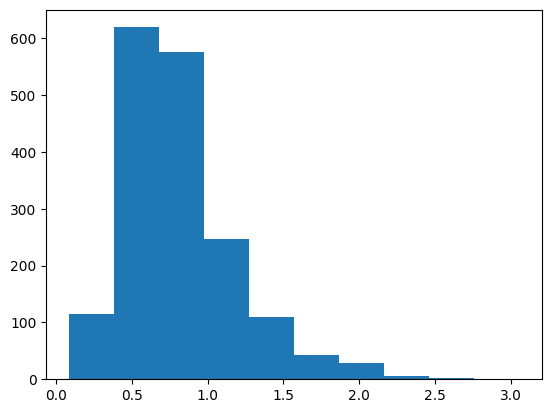

In [78]:
plt.hist(df_second_stack_diff["m_second_flank_diff"])

In [79]:
(
    df_second_stack_diff.groupby(["m_second_flank_1", "m_second_flank_2"])
    .agg(
        mean_m_second_flank_diff=("m_second_flank_diff", "mean"),
        std_m_second_flank_diff=("m_second_flank_diff", "std"),
        count=("m_second_flank_diff", "count"),
    )
    .reset_index()
    .sort_values("mean_m_second_flank_diff", ascending=False)
)

,m_second_flank_1,m_second_flank_2,mean_m_second_flank_diff,std_m_second_flank_diff,count
154,GC-GC,GC-AU,1.295937,0.273999,6
94,CG-GC,GC-AU,1.255165,0.568041,13
118,GC-AU,AU-GC,1.252014,0.585355,8
100,CG-GC,UA-GC,1.246774,0.962551,2
204,UA-GC,AU-AU,1.196591,0.478164,11
...,...,...,...,...,...
187,UA-AU,UA-GC,0.479809,0.293987,5
226,UA-UA,CG-UA,0.348717,0.172449,2
203,UA-CG,UA-UA,0.345027,0.026636,2
107,CG-UA,CG-CG,0.243937,NaN,1


In [80]:
df_sub = df_non_wc.query("m_sequence == 'AUCA&UAUU' and r_loc_pos == 6").copy()

In [81]:
heatmap_table(df_sub, "m_second_flank_bp_5p", "m_second_flank_bp_3p", "ln_r_data")

m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,-6.2,-4.4,-4.6,-5.1
CG,-5.4,-4.1,nan,-4.9
GC,-5.3,-3.8,-3.7,-4.2
UA,-5.5,-4.1,-4.2,-4.6
m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,0.47,0.69,0.47,0.47
CG,0.60,0.39,nan,0.67
GC,0.72,0.13,0.28,0.35


In [82]:
df_sub.groupby(["m_second_flank_bp_5p"]).agg(
    mean_ln_r_data=("ln_r_data", "mean"),
    std_ln_r_data=("ln_r_data", "std"),
    count=("ln_r_data", "count"),
).reset_index()

,m_second_flank_bp_5p,mean_ln_r_data,std_ln_r_data,count
0,AU,-5.073243,0.777292,24
1,CG,-4.896248,0.784391,18
2,GC,-4.393824,0.834225,24
3,UA,-4.740731,0.730648,37


In [83]:
df_sub.groupby(["m_second_flank_bp_3p"]).agg(
    mean_ln_r_data=("ln_r_data", "mean"),
    std_ln_r_data=("ln_r_data", "std"),
    count=("ln_r_data", "count"),
).reset_index()

,m_second_flank_bp_3p,mean_ln_r_data,std_ln_r_data,count
0,AU,-5.553040,0.640102,30
1,CG,-4.041460,0.492963,18
2,GC,-4.265955,0.540781,18
3,UA,-4.719579,0.574986,37


In [84]:
df_sub.groupby(["m_orientation"]).agg(
    mean_ln_r_data=("ln_r_data", "mean"),
    std_ln_r_data=("ln_r_data", "std"),
    count=("ln_r_data", "count"),
).reset_index()

,m_orientation,mean_ln_r_data,std_ln_r_data,count
0,flipped,-4.867015,0.735497,51
1,non-flipped,-4.664064,0.856246,52


In [85]:
df_sub.groupby(["m_second_flank_bp_3p", "m_second_flank_bp_5p"]).agg(
    mean_ln_r_data=("ln_r_data", "mean"),
    std_ln_r_data=("ln_r_data", "std"),
    count=("ln_r_data", "count"),
).reset_index().sort_values("mean_ln_r_data", ascending=False)

,m_second_flank_bp_3p,m_second_flank_bp_5p,mean_ln_r_data,std_ln_r_data,count
9,GC,GC,-3.689883,0.284291,4
6,CG,GC,-3.783077,0.131130,6
5,CG,CG,-4.075995,0.385118,5
7,CG,UA,-4.114415,0.750608,4
10,GC,UA,-4.179975,0.396283,6
13,UA,GC,-4.221359,0.348794,6
4,CG,AU,-4.403395,0.685903,3
8,GC,AU,-4.618476,0.474782,8
14,UA,UA,-4.636757,0.527234,17
12,UA,CG,-4.949575,0.670846,6


In [86]:
# Create new columns flank_dg_1 and flank_dg_2
df_sub["flank_dg_1"] = df_sub.apply(
    lambda row: get_dg(row["m_second_flank_bp_5p"], row["m_flank_bp_5p"]), axis=1
)
df_sub["flank_dg_2"] = df_sub.apply(
    lambda row: get_dg(row["m_flank_bp_3p"], row["m_second_flank_bp_3p"]), axis=1
)
df_sub["flank_dg"] = df_sub["flank_dg_1"] + df_sub["flank_dg_2"]
df_sub_sum = (
    df_sub.groupby(["m_second_flank_bp_3p", "m_second_flank_bp_5p"])
    .agg(
        mean_ln_r_data=("ln_r_data", "mean"),
        mean_flank_dg=("flank_dg", "mean"),
        mean_flank_dg_1=("flank_dg_1", "mean"),
        mean_flank_dg_2=("flank_dg_2", "mean"),
        std_ln_r_data=("ln_r_data", "std"),
        count=("ln_r_data", "count"),
    )
    .reset_index()
    .sort_values("mean_ln_r_data", ascending=False)
)
df_sub_sum

,m_second_flank_bp_3p,m_second_flank_bp_5p,mean_ln_r_data,mean_flank_dg,mean_flank_dg_1,mean_flank_dg_2,std_ln_r_data,count
9,GC,GC,-3.689883,-4.43,-2.35,-2.08,0.284291,4
6,CG,GC,-3.783077,-4.59,-2.35,-2.24,0.131130,6
5,CG,CG,-4.075995,-4.35,-2.11,-2.24,0.385118,5
7,CG,UA,-4.114415,-3.57,-1.33,-2.24,0.750608,4
10,GC,UA,-4.179975,-3.41,-1.33,-2.08,0.396283,6
13,UA,GC,-4.221359,-3.45,-2.35,-1.10,0.348794,6
4,CG,AU,-4.403395,-3.17,-0.93,-2.24,0.685903,3
8,GC,AU,-4.618476,-3.01,-0.93,-2.08,0.474782,8
14,UA,UA,-4.636757,-2.43,-1.33,-1.10,0.527234,17
12,UA,CG,-4.949575,-3.21,-2.11,-1.10,0.670846,6


R-squared: 0.6765


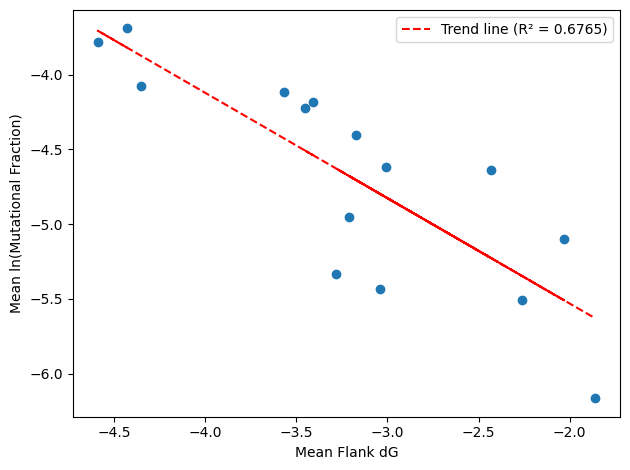

In [87]:
plt.scatter(df_sub_sum["mean_flank_dg"], df_sub_sum["mean_ln_r_data"])
plt.xlabel("Mean Flank dG")
plt.ylabel("Mean ln(Mutational Fraction)")
# Compute R-squared between mean_flank_dg and mean_ln_r_data
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_sub_sum["mean_flank_dg"], df_sub_sum["mean_ln_r_data"]
)
r_squared = r_value**2

print(f"R-squared: {r_squared:.4f}")

# Add a trend line to the scatter plot
x = df_sub_sum["mean_flank_dg"]
y = df_sub_sum["mean_ln_r_data"]
plt.plot(
    x,
    slope * x + intercept,
    color="red",
    linestyle="--",
    label=f"Trend line (R² = {r_squared:.4f})",
)
plt.legend()
plt.tight_layout()
plt.show()

In [88]:
df_sub.groupby(["m_second_flank_bp_3p", "m_second_flank_bp_5p"]).agg(
    mean_ln_r_data=("ln_r_data", "mean"),
    std_ln_r_data=("ln_r_data", "std"),
    count=("ln_r_data", "count"),
).reset_index().sort_values("mean_ln_r_data", ascending=False)

,m_second_flank_bp_3p,m_second_flank_bp_5p,mean_ln_r_data,std_ln_r_data,count
9,GC,GC,-3.689883,0.284291,4
6,CG,GC,-3.783077,0.131130,6
5,CG,CG,-4.075995,0.385118,5
7,CG,UA,-4.114415,0.750608,4
10,GC,UA,-4.179975,0.396283,6
13,UA,GC,-4.221359,0.348794,6
4,CG,AU,-4.403395,0.685903,3
8,GC,AU,-4.618476,0.474782,8
14,UA,UA,-4.636757,0.527234,17
12,UA,CG,-4.949575,0.670846,6


## Not using anymore

In [89]:
df_sub = (
    df_non_wc.groupby(["m_sequence", "r_loc_pos", "m_second_flank_bp_5p"])
    .agg(
        m_token=("m_token", "first"),
        likely_pair=("likely_pair", "first"),
        m_flank_bp_5p=("m_flank_bp_5p", "first"),
        mean_ln_r_data=("ln_r_data", "mean"),
        std_ln_r_data=("ln_r_data", "std"),
        count=("ln_r_data", "count"),
    )
    .query("m_token == '2x2'")
).reset_index()

data = []
for (sequence, position), group in df_sub.groupby(["m_sequence", "r_loc_pos"]):
    groups = (
        group.groupby(["m_second_flank_bp_5p"])
        .agg(
            mean_ln_r_data=("mean_ln_r_data", "mean"),
            count=("count", "sum"),
        )
        .reset_index()
        .sort_values("mean_ln_r_data", ascending=False)
    )
    max_row = groups.iloc[0]
    min_row = groups.iloc[-1]
    data.append(
        {
            "m_flank_bp_5p": group.iloc[0]["m_flank_bp_5p"],
            "m_sequence": sequence,
            "r_loc_pos": position,
            "m_second_flank_diff": max_row["mean_ln_r_data"]
            - min_row["mean_ln_r_data"],
            "m_second_flank_1": max_row["m_second_flank_bp_5p"],
            "m_second_flank_2": min_row["m_second_flank_bp_5p"],
            "count": (max_row["count"] + min_row["count"]) / 2,
        }
    )
df_sub_2 = pd.DataFrame(data)
df_sub_2.sort_values("m_second_flank_diff", ascending=False)

,m_flank_bp_5p,m_sequence,r_loc_pos,m_second_flank_diff,m_second_flank_1,m_second_flank_2,count
1058,GC,GAUA&UUAC,1,1.533749,CG,GC,22.0
1257,UA,UAUA&UCAA,1,1.414614,CG,UA,10.5
1263,UA,UAUA&UUAA,1,1.411183,GC,UA,26.5
1260,UA,UAUA&UCCA,1,1.294557,GC,UA,13.0
1267,UA,UAUA&UUGA,1,1.287033,CG,UA,12.5
...,...,...,...,...,...,...,...
467,AU,AUAA&UACU,7,0.024893,CG,UA,29.0
146,AU,AACG&CCAU,6,0.023579,UA,GC,12.0
544,AU,AUCU&AUUU,2,0.017520,GC,UA,33.0
882,CG,CGGA&UGAG,7,0.012270,AU,UA,23.0
